Loading data...
DELIVERY LAG PATTERN ANALYSIS

[1] CALCULATING LAGS
--------------------------------------------------------------------------------
Total receivals with lag data: 122537

Lag statistics (days):
count    122537.000000
mean        -35.592686
std          97.425576
min        -723.000000
25%         -26.000000
50%         -15.000000
75%          -4.000000
max         794.000000
Name: delivery_lag_days, dtype: float64

[2] ANALYZING SUPPLIER-SPECIFIC LAG PATTERNS
--------------------------------------------------------------------------------

Top 20 suppliers by number of deliveries:
             median_lag  mean_lag  std_lag  count
supplier_id                                      
52036             -19.0     -39.4     88.1  10753
10001              -3.0      -2.3      2.3   8419
52064             -19.0     -30.2     70.1   7175
69879             -19.0     -25.0     23.2   6351
63948             -17.0     -21.0     23.4   6209
50363             -15.0     -29.7     81.4   

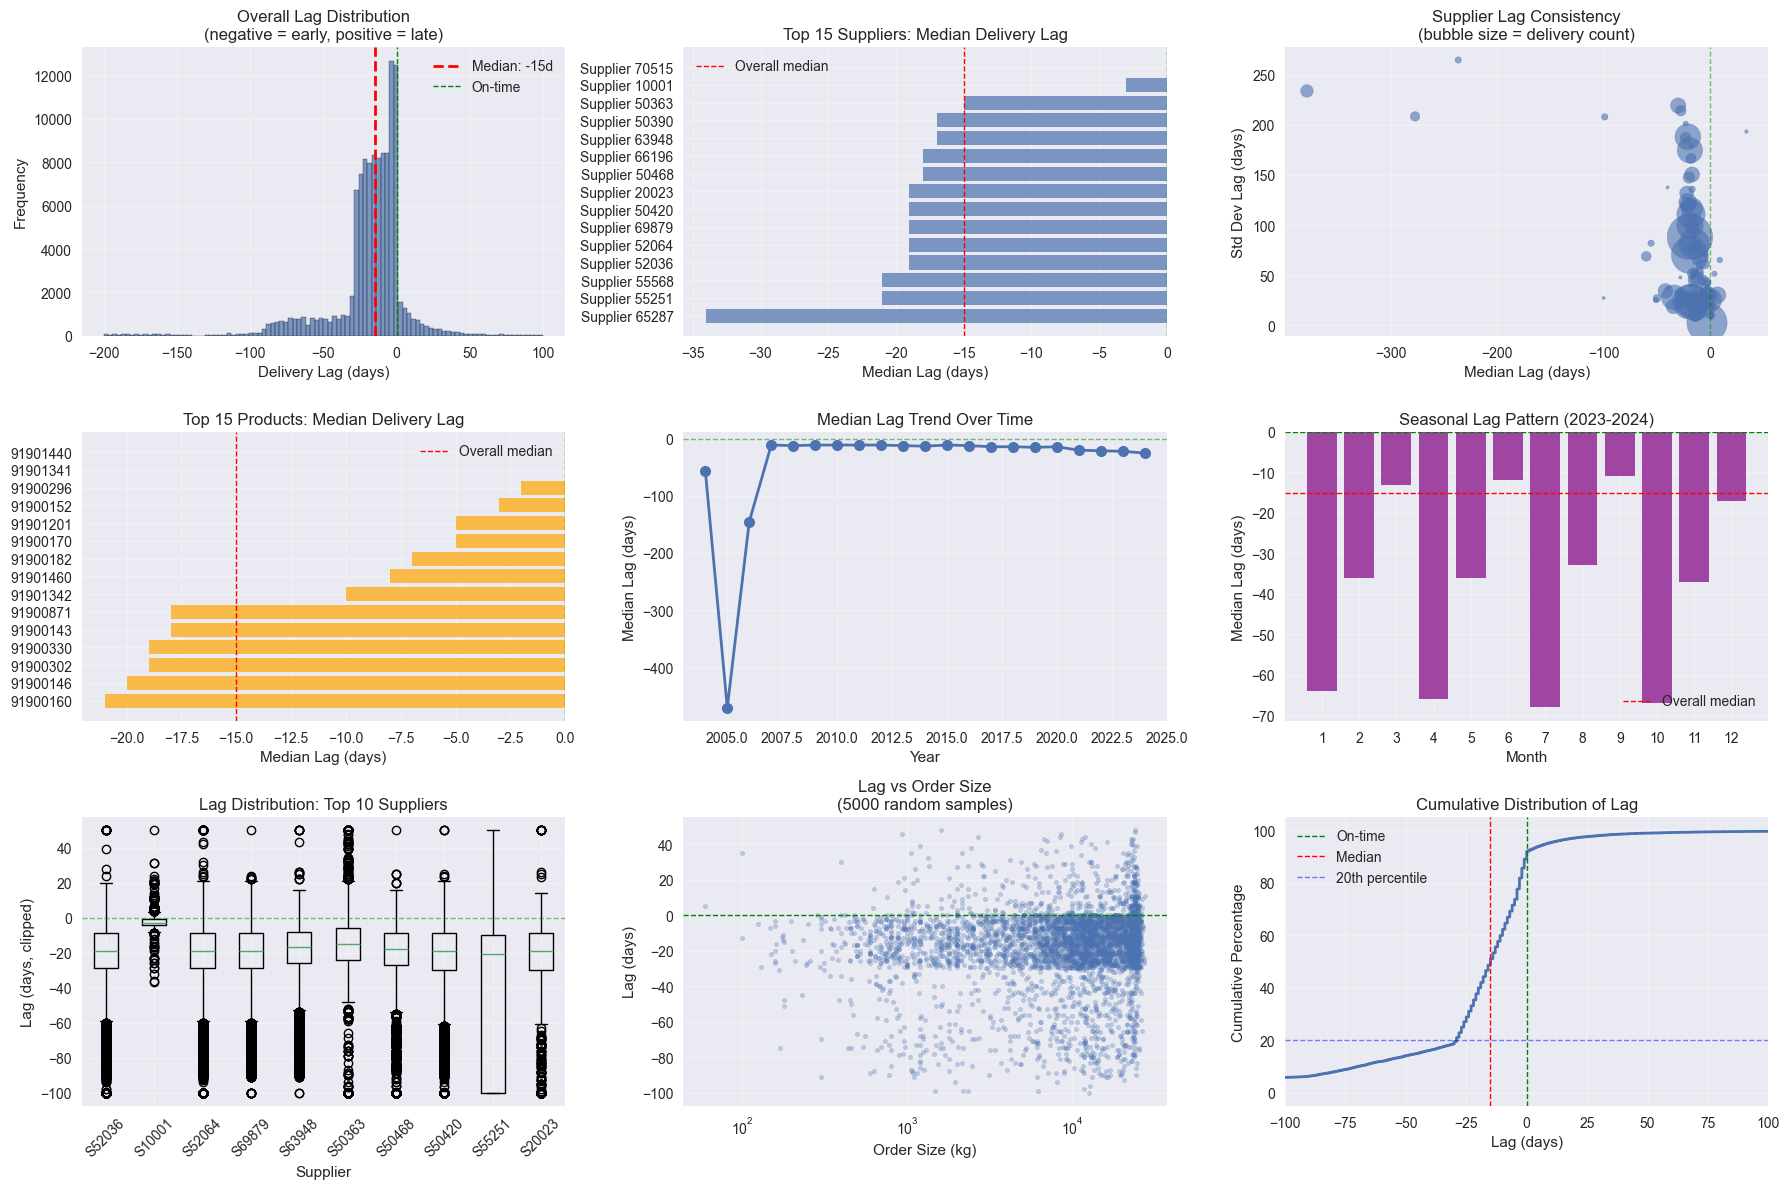

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-v0_8')

# Load data
print("Loading data...")
receivals = pd.read_csv('./Project_materials/data/kernel/receivals.csv')
purchase_orders = pd.read_csv('./Project_materials/data/kernel/purchase_orders.csv')

# Convert dates
receivals['date_arrival'] = pd.to_datetime(receivals['date_arrival'], utc=True).dt.tz_localize(None)
purchase_orders['delivery_date'] = pd.to_datetime(purchase_orders['delivery_date'], utc=True).dt.tz_localize(None)
purchase_orders['created_date_time'] = pd.to_datetime(purchase_orders['created_date_time'], utc=True).dt.tz_localize(None)

print("="*80)
print("DELIVERY LAG PATTERN ANALYSIS")
print("="*80)

# ============================================================================
# MERGE AND CALCULATE LAGS
# ============================================================================
print("\n[1] CALCULATING LAGS")
print("-"*80)

# Merge receivals with purchase orders
merged = receivals.merge(
    purchase_orders[['purchase_order_id', 'purchase_order_item_no', 'delivery_date', 
                     'created_date_time', 'quantity', 'product_id', 'status']],
    on=['purchase_order_id', 'purchase_order_item_no'],
    how='left',
    suffixes=('_receival', '_po')
)

# Calculate lags
merged['delivery_lag_days'] = (merged['date_arrival'] - merged['delivery_date']).dt.days
merged['creation_to_arrival_days'] = (merged['date_arrival'] - merged['created_date_time']).dt.days

# Clean: only keep rows with valid lag data
merged_clean = merged[merged['delivery_lag_days'].notna()].copy()

print(f"Total receivals with lag data: {len(merged_clean)}")
print(f"\nLag statistics (days):")
print(merged_clean['delivery_lag_days'].describe())

# ============================================================================
# SUPPLIER-SPECIFIC LAG PATTERNS
# ============================================================================
print("\n[2] ANALYZING SUPPLIER-SPECIFIC LAG PATTERNS")
print("-"*80)

supplier_lag_stats = merged_clean.groupby('supplier_id').agg({
    'delivery_lag_days': ['median', 'mean', 'std', 'count']
}).round(1)
supplier_lag_stats.columns = ['median_lag', 'mean_lag', 'std_lag', 'count']
supplier_lag_stats = supplier_lag_stats.sort_values('count', ascending=False)

# Show top 20 suppliers by volume
print("\nTop 20 suppliers by number of deliveries:")
print(supplier_lag_stats.head(20).to_string())

# Filter suppliers with significant data (at least 50 deliveries)
significant_suppliers = supplier_lag_stats[supplier_lag_stats['count'] >= 50].copy()
print(f"\nSuppliers with 50+ deliveries: {len(significant_suppliers)}")
print(f"Lag range across suppliers (median): {significant_suppliers['median_lag'].min():.1f} to {significant_suppliers['median_lag'].max():.1f} days")
print(f"Std dev across suppliers (median): {significant_suppliers['std_lag'].mean():.1f} days")

# ============================================================================
# PRODUCT-SPECIFIC LAG PATTERNS
# ============================================================================
print("\n[3] ANALYZING PRODUCT-SPECIFIC LAG PATTERNS")
print("-"*80)

# Use product_id from receival (the actual product received)
product_lag_stats = merged_clean.groupby('product_id_receival').agg({
    'delivery_lag_days': ['median', 'mean', 'std', 'count']
}).round(1)
product_lag_stats.columns = ['median_lag', 'mean_lag', 'std_lag', 'count']
product_lag_stats = product_lag_stats.sort_values('count', ascending=False)

print("\nTop 20 products by number of deliveries:")
print(product_lag_stats.head(20).to_string())

significant_products = product_lag_stats[product_lag_stats['count'] >= 50].copy()
print(f"\nProducts with 50+ deliveries: {len(significant_products)}")
print(f"Lag range across products (median): {significant_products['median_lag'].min():.1f} to {significant_products['median_lag'].max():.1f} days")

# ============================================================================
# TEMPORAL PATTERNS (HAS LAG CHANGED OVER TIME?)
# ============================================================================
print("\n[4] ANALYZING TEMPORAL LAG PATTERNS")
print("-"*80)

# Add year and month
merged_clean['year'] = merged_clean['date_arrival'].dt.year
merged_clean['month'] = merged_clean['date_arrival'].dt.month

# Yearly lag trends
yearly_lag = merged_clean.groupby('year').agg({
    'delivery_lag_days': ['median', 'mean', 'count']
}).round(1)
yearly_lag.columns = ['median_lag', 'mean_lag', 'count']

print("\nLag by year:")
print(yearly_lag.to_string())

# Monthly lag (recent years only)
recent_data = merged_clean[merged_clean['year'] >= 2023].copy()
monthly_lag = recent_data.groupby('month').agg({
    'delivery_lag_days': ['median', 'mean', 'count']
}).round(1)
monthly_lag.columns = ['median_lag', 'mean_lag', 'count']

print("\nLag by month (2023-2024):")
print(monthly_lag.to_string())

# ============================================================================
# RM_ID PATTERNS (for prediction targets)
# ============================================================================
print("\n[5] ANALYZING LAG PATTERNS FOR KEY RM_IDS")
print("-"*80)

# Top 10 most active rm_ids in 2024
top_rm_ids_2024 = merged_clean[merged_clean['year'] == 2024].groupby('rm_id').agg({
    'net_weight': 'sum',
    'delivery_lag_days': ['median', 'count']
}).round(1)
top_rm_ids_2024.columns = ['total_weight', 'median_lag', 'count']
top_rm_ids_2024 = top_rm_ids_2024.sort_values('total_weight', ascending=False).head(10)

print("\nTop 10 rm_ids in 2024 (by weight) and their median lag:")
print(top_rm_ids_2024.to_string())

# ============================================================================
# VISUALIZATIONS
# ============================================================================
print("\n[6] CREATING VISUALIZATIONS")
print("-"*80)

fig = plt.figure(figsize=(18, 12))

# Plot 1: Overall lag distribution (zoomed to reasonable range)
ax1 = plt.subplot(3, 3, 1)
lag_reasonable = merged_clean[
    (merged_clean['delivery_lag_days'] >= -200) & 
    (merged_clean['delivery_lag_days'] <= 100)
]['delivery_lag_days']
ax1.hist(lag_reasonable, bins=100, edgecolor='black', alpha=0.7)
ax1.axvline(merged_clean['delivery_lag_days'].median(), color='red', 
            linestyle='--', linewidth=2, label=f'Median: {merged_clean["delivery_lag_days"].median():.0f}d')
ax1.axvline(0, color='green', linestyle='--', linewidth=1, label='On-time')
ax1.set_xlabel('Delivery Lag (days)')
ax1.set_ylabel('Frequency')
ax1.set_title('Overall Lag Distribution\n(negative = early, positive = late)')
ax1.legend()
ax1.grid(alpha=0.3)

# Plot 2: Top 15 suppliers - median lag
ax2 = plt.subplot(3, 3, 2)
top_suppliers = supplier_lag_stats.head(15).sort_values('median_lag')
ax2.barh(range(len(top_suppliers)), top_suppliers['median_lag'], alpha=0.7)
ax2.set_yticks(range(len(top_suppliers)))
ax2.set_yticklabels([f"Supplier {int(idx)}" for idx in top_suppliers.index])
ax2.axvline(0, color='green', linestyle='--', linewidth=1)
ax2.axvline(merged_clean['delivery_lag_days'].median(), color='red', 
            linestyle='--', linewidth=1, label='Overall median')
ax2.set_xlabel('Median Lag (days)')
ax2.set_title('Top 15 Suppliers: Median Delivery Lag')
ax2.legend()
ax2.grid(alpha=0.3)

# Plot 3: Supplier lag variability (median vs std)
ax3 = plt.subplot(3, 3, 3)
scatter_data = significant_suppliers
ax3.scatter(scatter_data['median_lag'], scatter_data['std_lag'], 
            s=scatter_data['count']/10, alpha=0.6)
ax3.set_xlabel('Median Lag (days)')
ax3.set_ylabel('Std Dev Lag (days)')
ax3.set_title('Supplier Lag Consistency\n(bubble size = delivery count)')
ax3.axvline(0, color='green', linestyle='--', linewidth=1, alpha=0.5)
ax3.grid(alpha=0.3)

# Plot 4: Top 15 products - median lag
ax4 = plt.subplot(3, 3, 4)
top_products = product_lag_stats.head(15).sort_values('median_lag')
ax4.barh(range(len(top_products)), top_products['median_lag'], alpha=0.7, color='orange')
ax4.set_yticks(range(len(top_products)))
ax4.set_yticklabels([f"{int(idx)}" for idx in top_products.index])
ax4.axvline(0, color='green', linestyle='--', linewidth=1)
ax4.axvline(merged_clean['delivery_lag_days'].median(), color='red', 
            linestyle='--', linewidth=1, label='Overall median')
ax4.set_xlabel('Median Lag (days)')
ax4.set_title('Top 15 Products: Median Delivery Lag')
ax4.legend()
ax4.grid(alpha=0.3)

# Plot 5: Lag over time (yearly)
ax5 = plt.subplot(3, 3, 5)
yearly_lag_filtered = yearly_lag[yearly_lag['count'] >= 100]
ax5.plot(yearly_lag_filtered.index, yearly_lag_filtered['median_lag'], 
         marker='o', linewidth=2, markersize=8)
ax5.axhline(0, color='green', linestyle='--', linewidth=1, alpha=0.5)
ax5.set_xlabel('Year')
ax5.set_ylabel('Median Lag (days)')
ax5.set_title('Median Lag Trend Over Time')
ax5.grid(alpha=0.3)

# Plot 6: Lag by month (2023-2024)
ax6 = plt.subplot(3, 3, 6)
ax6.bar(monthly_lag.index, monthly_lag['median_lag'], alpha=0.7, color='purple')
ax6.axhline(0, color='green', linestyle='--', linewidth=1)
ax6.axhline(merged_clean['delivery_lag_days'].median(), color='red', 
            linestyle='--', linewidth=1, label='Overall median')
ax6.set_xlabel('Month')
ax6.set_ylabel('Median Lag (days)')
ax6.set_title('Seasonal Lag Pattern (2023-2024)')
ax6.set_xticks(range(1, 13))
ax6.legend()
ax6.grid(alpha=0.3)

# Plot 7: Box plot of lag by supplier (top 10)
ax7 = plt.subplot(3, 3, 7)
top_10_suppliers = supplier_lag_stats.head(10).index
supplier_box_data = [
    merged_clean[merged_clean['supplier_id'] == sup]['delivery_lag_days'].clip(-100, 50)
    for sup in top_10_suppliers
]
ax7.boxplot(supplier_box_data, labels=[f"S{int(s)}" for s in top_10_suppliers])
ax7.axhline(0, color='green', linestyle='--', linewidth=1, alpha=0.5)
ax7.set_ylabel('Lag (days, clipped)')
ax7.set_xlabel('Supplier')
ax7.set_title('Lag Distribution: Top 10 Suppliers')
ax7.grid(alpha=0.3)
plt.setp(ax7.xaxis.get_majorticklabels(), rotation=45)

# Plot 8: Lag vs order size
ax8 = plt.subplot(3, 3, 8)
sample_data = merged_clean.sample(min(5000, len(merged_clean)))
sample_data = sample_data[
    (sample_data['delivery_lag_days'] >= -100) & 
    (sample_data['delivery_lag_days'] <= 50)
]
ax8.scatter(sample_data['net_weight'], sample_data['delivery_lag_days'], 
            alpha=0.3, s=10)
ax8.axhline(0, color='green', linestyle='--', linewidth=1)
ax8.set_xlabel('Order Size (kg)')
ax8.set_ylabel('Lag (days)')
ax8.set_title('Lag vs Order Size\n(5000 random samples)')
ax8.set_xscale('log')
ax8.grid(alpha=0.3)

# Plot 9: Cumulative distribution of lag
ax9 = plt.subplot(3, 3, 9)
sorted_lag = np.sort(merged_clean['delivery_lag_days'].dropna())
cumulative = np.arange(1, len(sorted_lag) + 1) / len(sorted_lag) * 100
ax9.plot(sorted_lag, cumulative, linewidth=2)
ax9.axvline(0, color='green', linestyle='--', linewidth=1, label='On-time')
ax9.axvline(merged_clean['delivery_lag_days'].median(), color='red', 
            linestyle='--', linewidth=1, label='Median')
ax9.axhline(20, color='blue', linestyle='--', linewidth=1, alpha=0.5, label='20th percentile')
ax9.set_xlabel('Lag (days)')
ax9.set_ylabel('Cumulative Percentage')
ax9.set_title('Cumulative Distribution of Lag')
ax9.set_xlim(-100, 100)
ax9.legend()
ax9.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('lag_pattern_analysis.png', dpi=300, bbox_inches='tight')
print("Saved visualization to 'lag_pattern_analysis.png'")

# ============================================================================
# KEY INSIGHTS SUMMARY
# ============================================================================
print("\n" + "="*80)
print("KEY INSIGHTS FOR LAG MODELING")
print("="*80)

print("\n1. OVERALL PATTERN:")
print(f"   - Median lag: {merged_clean['delivery_lag_days'].median():.1f} days (EARLY)")
print(f"   - Mean lag: {merged_clean['delivery_lag_days'].mean():.1f} days")
print(f"   - 75% of deliveries arrive at least {-merged_clean['delivery_lag_days'].quantile(0.75):.0f} days early")

print("\n2. SUPPLIER VARIATION:")
print(f"   - {len(significant_suppliers)} suppliers with 50+ deliveries")
print(f"   - Median lag range: {significant_suppliers['median_lag'].min():.1f} to {significant_suppliers['median_lag'].max():.1f} days")
print(f"   - Difference: {significant_suppliers['median_lag'].max() - significant_suppliers['median_lag'].min():.1f} days")
variation = significant_suppliers['median_lag'].std()
print(f"   - Std dev of supplier medians: {variation:.1f} days")

if variation > 10:
    print("   ✅ SIGNIFICANT variation across suppliers - supplier-specific lag modeling RECOMMENDED!")
else:
    print("   ⚠️  Limited variation across suppliers - global lag may be sufficient")

print("\n3. PRODUCT VARIATION:")
if len(significant_products) > 0:
    print(f"   - {len(significant_products)} products with 50+ deliveries")
    print(f"   - Median lag range: {significant_products['median_lag'].min():.1f} to {significant_products['median_lag'].max():.1f} days")
    prod_variation = significant_products['median_lag'].std()
    print(f"   - Std dev of product medians: {prod_variation:.1f} days")
    
    if prod_variation > 10:
        print("   ✅ SIGNIFICANT variation across products - product-specific lag modeling RECOMMENDED!")
    else:
        print("   ⚠️  Limited variation across products - may not need product-specific lags")

print("\n4. TEMPORAL STABILITY:")
recent_years = yearly_lag[yearly_lag.index >= 2020]
if len(recent_years) > 1:
    lag_change = recent_years['median_lag'].max() - recent_years['median_lag'].min()
    print(f"   - Lag change over recent years: {lag_change:.1f} days")
    if abs(lag_change) < 10:
        print("   ✅ Lag is STABLE over time - historical patterns are reliable!")
    else:
        print("   ⚠️  Lag has changed over time - consider time-weighted averaging")

print("\n5. RECOMMENDATION:")
if variation > 10 or (len(significant_products) > 0 and prod_variation > 10):
    print("   🎯 USE LAG MODELING - Supplier/product-specific lags will improve predictions!")
    print("   📊 Estimated impact: Could improve score by 20-40%")
else:
    print("   🤔 OPTIONAL - Global lag (-15 days) may be sufficient")

print("\n" + "="*80)